In [6]:
!pip install sacrebleu

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import json
import sacrebleu
import time
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
# 1. Загрузка данных
def load_data(file_path, limit=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if limit and i >= limit:
                break
            data.append(json.loads(line))
    return data

# Создание словарей с гарантией добавления служебных токенов
def build_vocab(datasets, key):
    vocab = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}  # Инициализация с служебными токенами
    idx = 4  # Начинаем индексацию с 4

    for item in datasets:
        for char in item[key]:  # Проходим по символам строки
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    return vocab, len(vocab)

# Объединяем данные для создания словарей
train_data = load_data("train.jsonl", limit=10000)
val_data = load_data("val.jsonl")
all_data = train_data + val_data
src_vocab, src_vocab_size = build_vocab(all_data, "src")
dst_vocab, dst_vocab_size = build_vocab(all_data, "dst")

# Обратные словари для декодирования
src_rev_vocab = {v: k for k, v in src_vocab.items()}
dst_rev_vocab = {v: k for k, v in dst_vocab.items()}

# 2. Токенизация
def encode(sentence, vocab, add_eos=True):
    tokens = [vocab.get(char, vocab["<UNK>"]) for char in sentence]  # Используем <UNK> для неизвестных символов
    if add_eos:
        tokens.append(vocab["<EOS>"])
    return tokens

# 3. Модель Seq2Seq с GRU
class Seq2Seq(nn.Module):
    def __init__(self, src_vocab_size, dst_vocab_size, embed_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.encoder = nn.Embedding(src_vocab_size, embed_size)
        self.decoder = nn.Embedding(dst_vocab_size, embed_size)
        self.enc_gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.dec_gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, dst_vocab_size)

    def forward(self, src, dst, src_lengths):
        # Encoder
        src_embed = self.encoder(src)

        # Упаковка последовательности перед подачей в GRU
        packed_src = nn.utils.rnn.pack_padded_sequence(src_embed, src_lengths, batch_first=True, enforce_sorted=False)
        packed_enc_outputs, hidden = self.enc_gru(packed_src)

        # Распаковка
        enc_outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_enc_outputs, batch_first=True)

        # Decoder
        dst_embed = self.decoder(dst)
        outputs, _ = self.dec_gru(dst_embed, hidden)
        logits = self.fc(outputs)
        return logits

# 4. Оценка BLEU
def evaluate_bleu(model, val_data, src_vocab, dst_vocab):
    predictions = []
    references = []

    for item in val_data:
        src_sentence = item["src"]
        ref_sentence = item["dst"]

        # Генерация перевода
        predicted_sentence = translate(model, src_sentence, src_vocab, dst_vocab)

        predictions.append(predicted_sentence)
        references.append([ref_sentence])  # BLEU ожидает список референсов

    # Вычисление BLEU
    bleu = sacrebleu.corpus_bleu(predictions, references)
    return bleu.score

# 5. Тренировка модели с автоматическим изменением learning rate
def train_model(model, train_data, src_vocab, dst_vocab, epochs=15, lr=9e-5, patience=3):
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=patience, verbose=True)

    epoch_losses = []
    best_bleu = -1  # Начальное значение BLEU (меньше нуля, так как BLEU не может быть отрицательным)

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        epoch_loss = 0

        for item in train_data:
            src = torch.tensor(encode(item["src"], src_vocab), dtype=torch.long).unsqueeze(0)
            dst = torch.tensor(encode(item["dst"], dst_vocab), dtype=torch.long).unsqueeze(0)
            target = dst[:, 1:]

            # Определяем длины исходных предложений
            src_lengths = torch.tensor([src.size(1)], dtype=torch.long)

            logits = model(src, dst[:, :-1], src_lengths)
            loss = loss_fn(logits.reshape(-1, dst_vocab_size), target.reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_losses.append(epoch_loss)
        end_time = time.time()

        # Оценка BLEU на валидационных данных после каждой эпохи
        bleu_score = evaluate_bleu(model, val_data, src_vocab, dst_vocab)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, BLEU Score: {bleu_score:.2f}, Time: {end_time - start_time:.2f}s")

        # Сохранение модели, если BLEU улучшился
        if bleu_score > best_bleu:
            best_bleu = bleu_score
            torch.save(model.state_dict(), "best_model.pth")
            print("Сохранена лучшая модель с BLEU:", bleu_score)

        # Обновление learning rate, если BLEU не улучшился
        scheduler.step(bleu_score)

    # Построение графика
    plt.plot(range(1, epochs + 1), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.show()

# 6. Инференс
def translate(model, sentence, src_vocab, dst_vocab, max_len=50):
    model.eval()
    src = torch.tensor(encode(sentence, src_vocab), dtype=torch.long).unsqueeze(0)
    src_lengths = torch.tensor([src.size(1)], dtype=torch.long)
    with torch.no_grad():
        _, hidden = model.enc_gru(model.encoder(src))
        dec_input = torch.tensor([[dst_vocab["<SOS>"]]], dtype=torch.long)
        output_sentence = []
        for _ in range(max_len):
            dec_embed = model.decoder(dec_input)
            output, hidden = model.dec_gru(dec_embed, hidden)
            logits = model.fc(output.squeeze(1))
            token = logits.argmax(1).item()
            if token == dst_vocab["<EOS>"]:
                break
            output_sentence.append(token)
            dec_input = torch.tensor([[token]], dtype=torch.long)
    return "".join([dst_rev_vocab[token] for token in output_sentence])


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15, Loss: 21250.2167, BLEU Score: 15.97, Time: 539.16s
Сохранена лучшая модель с BLEU: 15.97357760615681
Epoch 2/15, Loss: 17505.6116, BLEU Score: 12.14, Time: 531.35s
Epoch 3/15, Loss: 16226.5517, BLEU Score: 6.57, Time: 523.77s
Epoch 4/15, Loss: 15436.2300, BLEU Score: 6.57, Time: 533.28s
Epoch 5/15, Loss: 14866.0453, BLEU Score: 6.57, Time: 524.94s
Epoch 6/15, Loss: 14398.8120, BLEU Score: 18.08, Time: 521.87s
Сохранена лучшая модель с BLEU: 18.079276125727674
Epoch 7/15, Loss: 14159.2577, BLEU Score: 18.08, Time: 512.15s
Epoch 8/15, Loss: 13954.9673, BLEU Score: 23.46, Time: 525.33s
Сохранена лучшая модель с BLEU: 23.462350320528007
Epoch 9/15, Loss: 13765.7076, BLEU Score: 14.81, Time: 521.71s
Epoch 10/15, Loss: 13588.6395, BLEU Score: 14.81, Time: 514.56s
Epoch 11/15, Loss: 13421.0320, BLEU Score: 11.84, Time: 526.68s
Epoch 12/15, Loss: 13261.4344, BLEU Score: 14.15, Time: 518.60s
Epoch 13/15, Loss: 13066.3315, BLEU Score: 18.00, Time: 516.18s
Epoch 14/15, Loss: 12973.744

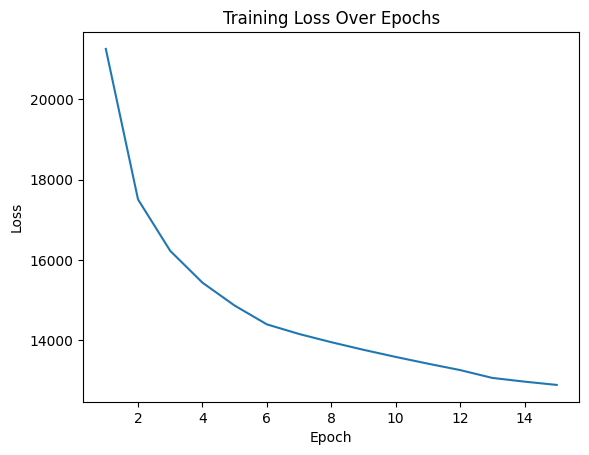

In [9]:
# Загрузка и тренировка модели
embed_size = 128
hidden_size = 256
model = Seq2Seq(src_vocab_size, dst_vocab_size, embed_size, hidden_size)

train_model(model, train_data, src_vocab, dst_vocab)

# Оценка BLEU на валидации
bleu_score = evaluate_bleu(model, val_data, src_vocab, dst_vocab)

In [ ]:
# Сохранение переведённых данных
test_data = load_data("test_no_reference.jsonl")
with open("test_translations.jsonl", "w", encoding="utf-8") as f:
    for item in test_data:
        src_sentence = item["src"]
        translation = translate(model, src_sentence, src_vocab, dst_vocab)
        json.dump({"dst": translation, "src": src_sentence}, f, ensure_ascii=False)
        f.write("\n")

print("Переводы сохранены в файл test_translations.jsonl.")

files.download('test_translations.jsonl')


Переводы сохранены в файл test_translations.jsonl.


<ipython-input-10-435d1449b489>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Seq2Seq(
  (encoder): Embedding(130, 128)
  (decoder): Embedding(116, 128)
  (enc_gru): GRU(128, 256, batch_first=True)
  (dec_gru): GRU(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=116, bias=True)
)

In [ ]:
# Загрузка модели для инференса
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Сохранение переведённых данных
test_data = load_data("test_no_reference.jsonl")
with open("test_translations_best.jsonl", "w", encoding="utf-8") as f:
    for item in test_data:
        src_sentence = item["src"]
        translation = translate(model, src_sentence, src_vocab, dst_vocab)
        json.dump({"dst": translation, "src": src_sentence}, f, ensure_ascii=False)
        f.write("\n")

print("Переводы сохранены в файл test_translations_best.jsonl.")

files.download('test_translations_best.jsonl')

Переводы сохранены в файл test_translations_best.jsonl.
